##### 1.  Importación de librerías requeridas

In [1]:
# !pip install skforecast
# !pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 6.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.5 MB/s eta 0:00:00


In [2]:
# Manipulación datos
import numpy as np
import pandas as pd

from numpy import array
#from keras.models import Sequential
#from keras.layers import Dense
from numpy import asarray
from pandas import DataFrame
from pandas import concat

# Gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelación y pronóstico
#Random Forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


from joblib import dump, load


from datetime import datetime
from math import sqrt
# Configuración de warnings:
import warnings
# warnings.filterwarnings('ignore')

In [3]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

##### 2.  Descarga de datos financieros

In [4]:
start = '2016-05-01'
end = '2018-01-28'
meta = pdr.get_data_yahoo("META", start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [5]:
meta.head()

Date
2016-05-02    118.570000
2016-05-03    117.430000
2016-05-04    118.059998
2016-05-05    117.809998
2016-05-06    119.489998
Name: Close, dtype: float64

In [6]:
#pasamos a data frame los datos
dt= pandas.DataFrame(meta)
dt.head()

,Close
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998


In [7]:
#Identificamos la longitud de la serie
len(dt)

439

In [8]:
#Damos un vistazo a los datos
dt.head()
dt.tail()
data = dt.rename(columns={'Close': 'y'})
data

,y
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998
...,...
2018-01-22,185.369995
2018-01-23,189.350006
2018-01-24,186.550003


##### 3. Visualización de serie de interés

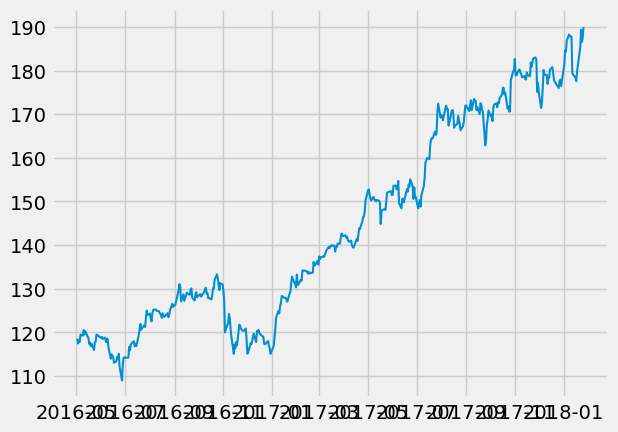

In [9]:
#Graficamos la serie dt.
plt.plot(dt)

##### 4. Pre procesamiento de datos

In [35]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(data.index)

In [36]:
#Ahora, a numpy array:
dt2= meta.to_numpy()

In [37]:
#Y generamos un rearreglo de la dimensión del array a 1D, en los renglones (el -1 signigica que numpy calcula este número por nosotros).
close_data = dt2.reshape((-1,1))

##### 5. Partición de datos de entrenamiento y prueba

In [77]:
#Especificamos primeramente el porcentje del corte.
split_percent = 0.05
split = int(split_percent*len(dataindex))

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
data_train = data[:-split]
data_test = data[-split:]

date_train = dataindex[:-split]
date_test = dataindex[-split:]

In [78]:
#imprimimos la longitud de ambos conjuntos de datos:
print(len(data_train))
print(len(data_test))

418
21


##### 6. Visualización conjunto de entrenamiento y prueba

In [79]:
#Graficamos la serie anterior, aunando el valor del pronóstico.
trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'test'
)

layout = go.Layout(
    title = "Meta Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

##### 7. Creación Forecaster

In [80]:
# Creamos y entrenamos el modelo de Random Forest con la función de estructura de datos generada a través de la función Forecaster, en este caso, creando ventanas de 10 días:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 10
                )

forecaster.fit(y=data_train['y'])

##### 8. Predicciones en conjunto de prueba

In [85]:
# Pronóstico, en este caso elegimos una ventana de 10 días.
# ==============================================================================
steps = 10
predictions = forecaster.predict(steps=split)
predictions.head(5)

10    176.935000
11    177.953900
12    179.187500
13    179.430100
14    179.820699
Name: pred, dtype: float64

In [86]:
len(predictions)

21

In [87]:
# Determinamos el error de pronóstico:
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")
RMSE = sqrt(error_mse)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 37.659256009605855
Test error (rmse): 6.136713779345249


##### 9. Refinamiento de los hiperparámetros

In [88]:
# Cálculo de hiperparámetros por grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10 # Este valor se reemplazará en la grilla
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:55<00:00, 57.50s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 44.25063243957347



In [89]:
# Visualizamos los resultados del grid search
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",44.250632,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",44.868164,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",46.234359,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",46.342456,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",48.646983,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",49.357600,10,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",49.591236,5,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",50.012887,5,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",56.940089,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",56.963254,3,100


##### 10. Aplicación modelo óptimo a serie completa

In [104]:
# Configuramos la función de pronóstico de forecaster con la mejor combinación obteida de hiperparámetros.
# ==============================================================================
### Aquí debe ir tu codigo, 
regressor = RandomForestRegressor(max_depth= 5, n_estimators=100 , random_state=123)
### Hasta aquí modificas

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data['y'])

In [105]:
# Podemos imprimir la importancia de los rezagos
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.445699
1,lag_2,0.107251
2,lag_3,0.179152
3,lag_4,0.055643
4,lag_5,0.154614
5,lag_6,0.034332
6,lag_7,0.013629
7,lag_8,0.003353
8,lag_9,0.005511
9,lag_10,0.000817


##### 11. Generación del pronóstico hacia adelante

In [106]:
# Pronóstico, en este caso elegimos una ventana de 20 días.
# ==============================================================================
steps = 10
predictions = forecaster.predict(steps=steps)
predictions.head(5)

10    185.375791
11    185.550465
12    185.436206
13    183.807344
14    184.244479
Name: pred, dtype: float64

In [107]:
## Generamos las fechas a dichos pronósticos mediante la función de pandas date_range:
fin = data_test.index.max()   #Partimos de la fecha máxima de la sección de prueba, hacia adelante.
fwd_dates = pd.date_range(fin, periods=20).tolist()
fwd_dates

[Timestamp('2018-01-26 00:00:00', freq='D'),
 Timestamp('2018-01-27 00:00:00', freq='D'),
 Timestamp('2018-01-28 00:00:00', freq='D'),
 Timestamp('2018-01-29 00:00:00', freq='D'),
 Timestamp('2018-01-30 00:00:00', freq='D'),
 Timestamp('2018-01-31 00:00:00', freq='D'),
 Timestamp('2018-02-01 00:00:00', freq='D'),
 Timestamp('2018-02-02 00:00:00', freq='D'),
 Timestamp('2018-02-03 00:00:00', freq='D'),
 Timestamp('2018-02-04 00:00:00', freq='D'),
 Timestamp('2018-02-05 00:00:00', freq='D'),
 Timestamp('2018-02-06 00:00:00', freq='D'),
 Timestamp('2018-02-07 00:00:00', freq='D'),
 Timestamp('2018-02-08 00:00:00', freq='D'),
 Timestamp('2018-02-09 00:00:00', freq='D'),
 Timestamp('2018-02-10 00:00:00', freq='D'),
 Timestamp('2018-02-11 00:00:00', freq='D'),
 Timestamp('2018-02-12 00:00:00', freq='D'),
 Timestamp('2018-02-13 00:00:00', freq='D'),
 Timestamp('2018-02-14 00:00:00', freq='D')]

##### 12. Visualización del pronóstico futuro

In [108]:
#Graficamos la serie anterior, aunando el valor del pronóstico.
trace3 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'Test'
)

trace4 = go.Scatter(
    x = fwd_dates,
    y = predictions,
    mode = 'lines',
    name = 'Pronóstico Futuro Random Forest'
)

trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Train'
    )

layout = go.Layout(
    title = "Meta Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace3, trace4], layout=layout)
fig.show()